In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy.stats as stats
import math
from decimal import *
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import sobol
import nbimporter
from PINN_Solver_Classes import *
from PDE_Classes import *
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
# from keras import callbacks
# import time
# import itertools as product

# Set data type
DTYPE = 'float64'
tf.keras.backend.set_floatx(DTYPE)

In [ ]:
N_b = 1 # number of boundary and interface points
N_r = 2**10 # number of internal collocation points

# Declare PDE parameters
nu = 0.0001
beta = 1

if nu <= 1e-3:
    mu = np.log(( (nu/beta)**(nu/beta) )*(np.exp(1)))
else:
    mu = (nu/beta)*np.log( ( nu/beta )*( np.exp(beta/nu) - 1 ) )

# Declare bounds of each subdomain
sub = (
     [0, 0.3],
     [0.2, 0.5],
     [0.4, 0.7],
     [0.6, 0.9],
     [0.8, mu+0.005],
     [mu, 0.965],
     [0.96, 0.975],
     [0.97, 0.985],
     [0.98, 0.995],
     [0.99, 1]
     )
# Initialize list of points which lie on the boundary
BC = [0, 1]

# Lower bounds as TF scalars 
x0_om = tf.constant([x[0] for x in sub], dtype=DTYPE)
# Upper bounds as TF scalars 
x1_om = tf.constant([x[1] for x in sub], dtype=DTYPE)


# Generate boundary points for each subdomain boundary
# zipped booleans indicate whether a point is a model or interface boundary
X_b_om = [ tuple( zip( [tf.constant(np.repeat([[i]], N_b, axis=0), dtype=DTYPE) for i in sub[j]], [k in BC for k in sub[j]] ) ) 
          for j in range(len(sub)) ]


# Declare PDE first as a class for the PINN solver to inherit
pde = PDE_1D_Steady_AdvecDiff

# Then declare an instance of the PDE class to use in the Driver
pde1 = pde(nu=nu, beta=beta)

# Generate data for boundary conditions
# U_b = ()
# for b in X_b_om:
#     U_b += tuple( pde1.f_b(x) for x, y in b if y  )


In [ ]:
# Set random seed for reproducible results
tf.random.set_seed(0)

# Generate internal points with gaussian distribution about the shock
# mu = (nu/beta)*np.log( ( nu/beta )*( np.exp(beta/nu) - 1 ) )
# sigma = (x1_om[-1] - x0_om[0])/1.5
# x = stats.truncnorm((x0_om[0] - mu) / sigma, (x1_om[-1] - mu) / sigma, loc=mu, scale=sigma).rvs(N_r)

# Generate uniform internal points for the whole domain
points = sobol.sample(dimension=1, n_points=N_r)
xwidth = x1_om[-1] - x0_om[0]
x = xwidth*points + x0_om[0]


# def get_curvature(x):
#     u_x = (1/beta) - ( (beta/nu)*np.exp(beta*x/nu) )/( beta*(np.exp(beta/nu) - 1) )
#     u_xx = -((beta/nu)**2)*np.exp(beta*x/nu)/( beta*(np.exp(beta/nu) - 1) )

#     return np.abs(u_xx)/( (1 + u_x**2)**(3/2) )
    
    
# sample = 0
# max_length = 1/(2**15)
# max_curve_grad = 0.05
# x = np.array([sample])

# while sample < 1:
#     sample_next = sample + max_length
    
#     k_diff = np.abs(get_curvature(sample) - get_curvature(sample_next))
    
#     if not k_diff > max_curve_grad:
#         x = np.concatenate(( x, np.array([sample_next]) ), axis=0)
#         sample = sample_next
#         continue
    
#     sub_div = math.ceil(k_diff/max_curve_grad)
    
#     x = np.concatenate(( x, np.linspace(sample, sample_next, num=sub_div)[1:] ), axis=0)
    
#     sample = sample_next

##########################################################################################

# Store internal points as tensor object
X_r = tf.constant(x, shape=(len(x), 1), dtype=DTYPE)

# Split internal points by subdomain and store in tuple
X_r_om = ()
for i in range(len(x0_om)):
    mask = (X_r >= x0_om[i]) & (X_r <= x1_om[i])
    temp = tf.boolean_mask(X_r, mask)
    X_r_om += ( tf.constant(temp, shape=(temp.shape[0],1), dtype=DTYPE), )

In [ ]:
# Build a neural network to handle each domain and intialize data frame for loss
column_list = []
model_om = ()
for i in range(len(sub)):
    model_om += ( PINN_Architecture(x0_om[i], x1_om[i]), )
    model_om[i].build(input_shape=(None, X_r_om[i].shape[1]))
    column_list += ["model {:d} Phi_r".format(i+1), "model {:d} Phi_b".format(i+1), 
                        "model {:d} Phi_i".format(i+1), "model {:d} Loss".format(i+1)]

loss_frame = pd.DataFrame(columns=column_list)    

# Initialize Schwarz tolerance, iteration variables, and random initial guess for u
d_tol = 1e-4
schwarz_conv = 1
iterCount = 0
u_i_minus1 = tf.constant(np.random.rand(1001,1), shape=(1001, 1), dtype=DTYPE)

# Define learning rate schedule and choose optimizer (Adam)
lr = 1e-3 #tf.keras.optimizers.schedules.PiecewiseConstantDecay([64],[1e-3,1e-4])
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Declare hyperparameters
alpha = 0.25
numEpochs = 64
batch_size = 128

# Initialize variables for plotting Schwarz results
x = tf.constant(np.linspace(0, 1, num=1001), shape=(1001, 1), dtype=DTYPE)
x_om = [tf.constant(np.linspace(s[0], s[1], num=1001), shape=(1001, 1), dtype=DTYPE) for s in sub]
u_true = pde1.f(x)
fig = plt.figure()
subplot_rows=0
subplot_col=2
fig_store = ()
Schwarz_err = ()

# Main Schwarz loop
while schwarz_conv > d_tol:
    
    # Update plot format with increasing iterations
    if iterCount%subplot_col == 0:
        subplot_rows+=1
        gs = GridSpec(subplot_rows,subplot_col)
        for i, ax in enumerate(fig.axes):
            ax.set_position(gs[i].get_position(fig))
            ax.set_subplotspec(gs[i])
        fig.tight_layout(pad=1.0)
        fig.set_size_inches(3+subplot_rows*3, subplot_rows*3)
    
    ax = fig.add_subplot(subplot_rows,subplot_col,(iterCount%10 + 1))
    ax.set_xlabel('x', fontsize=16)
    ax.set_ylabel('u(x)', fontsize=16)
    
    iterCount += 1
    ax.set_title('Schwarz iteration {:d}'.format(iterCount), fontsize=16)

    ax.plot(x, u_true, 'k--')
    
    # intialize a new figure every 10 iterations to save new pages of results
    if iterCount%10 == 0:
        fig_store += (fig,)
        fig = plt.figure()
        fig.tight_layout(pad=1.0)
        subplot_rows=0
        subplot_col=2 
    
    # initialize tuples to contain loss for each PINN and current approximation, u, for each PINN
    loss_list = ()
    u_i_om = ()
    
    # loop over each model for training
    for s in range(len(model_om)):
        
        # Current model
        model_r = model_om[s]
        # Adjacent models for interface conditions
        model_i = model_om[s-1:s] + model_om[s+1:s+2]
        
        # Current model domain points
        X_r = X_r_om[s]
        # Current model boundary points
        X_b = X_b_om[s]
        

        # Initialize solver
        p3s = PINN_Solver_Schwarz_Steady(model_r, model_i, X_r, X_b, alpha, pde, nu=nu, beta=beta)

        # Solve PINN
        p3s.solve(tf.keras.optimizers.Adam(learning_rate=lr), batch_size, numEpochs)
        
        # Output loss results for each model
        print('Model {:d}: '.format(s+1))
        print('\t'+'Residual loss = {:10.8e}'.format(p3s.phi_r))
        print('\t'+'Boundary loss = {:10.8e}'.format(p3s.phi_b))
        print('\t'+'Interface loss = {:10.8e}'.format(p3s.phi_i))
        print('\t'+'Total loss = {:10.8e}'.format(p3s.loss))
        loss_list += (p3s.phi_r, p3s.phi_b, p3s.phi_i, p3s.loss)
        
        # Save current PINN approximations and add them to plot for current Schwarz iteration
        u_i_om += ( model_r(x_om[s]), )
        ax.plot(x_om[s], u_i_om[s])
        
    
    # Calculate average values for u summed across all models
    u_i = sum(u_i_om)/len(u_i_om)
    
    # Calculate the normalized difference between u for the current iteration and u for the previous iteration
    schwarz_conv = tf.math.reduce_euclidean_norm(u_i - u_i_minus1)/tf.math.reduce_euclidean_norm(u_i)
    
    # Update u for the previous iteration
    u_i_minus1 = u_i
    
    # Output current Schwarz error 
    print('\nSchwarz iteration {:d}: error = {:10.8e}'.format(iterCount, schwarz_conv), "\n")
    
    # Record loss and schwarz error history
    loss_frame.loc[iterCount-1] = loss_list
    Schwarz_err += (schwarz_conv,)
    
#     if iterCount == 50:
#         break

# Save all figures as PDFs
fig_store += (fig,)
for i,figure in enumerate(fig_store):
    figure.savefig("C:/Users/wdsnyde/code/fhnm-ldrd/Docs/Schwarz-PINNs/SchwarzIter_AdvecDiff_sub10_nu_{:1.0e}_beta_{:1.0e}_pg{:d}.pdf".format(nu,beta,i))

In [ ]:
# nu = 0.01
# beta = 1
# print((nu/beta)*np.log( ( nu/beta )*( np.exp(beta/nu) - 1 ) ))

# x = tf.constant(np.linspace(0, 1, num=1001), shape=(1001, 1), dtype=DTYPE)
# u = pde1.f(x)



# u_x = (1/beta) - ( (beta/nu)*np.exp(beta*x/nu) )/( beta*(np.exp(beta/nu) - 1) )
# u_xx = -((beta/nu)**2)*np.exp(beta*x/nu)/( beta*(np.exp(beta/nu) - 1) )

# kappa = tf.constant(np.abs(u_xx)/( (1 + u_x**2)**(3/2) ), dtype=DTYPE)
    


# fig = plt.figure()
# ax = fig.add_subplot(4,1,1)
# ax.set_xlabel('x', fontsize=16)
# ax.set_ylabel('u(x)', fontsize=16)
# ax.set_title('u(x)', fontsize=16)
# ax.plot(x, u, 'b-')

# ax = fig.add_subplot(4,1,2)
# ax.set_xlabel('x', fontsize=16)
# ax.set_ylabel("u'(x)", fontsize=16)
# ax.set_title('First derivative of u(x)', fontsize=16)
# ax.plot(x, u_x, 'r-')

# ax = fig.add_subplot(4,1,3)
# ax.set_xlabel('x', fontsize=16)
# ax.set_ylabel("u''(x)", fontsize=16)
# ax.set_title('Second deritave of u(x)', fontsize=16)
# ax.plot(x, u_xx, 'g-')

# ax = fig.add_subplot(4,1,4)
# ax.set_xlabel('x', fontsize=16)
# ax.set_ylabel("Kappa", fontsize=16)
# ax.set_title('Curvature of u(x)', fontsize=16)
# ax.plot(x, kappa, 'g-')


Text(0, 0.5, 'u(x)')

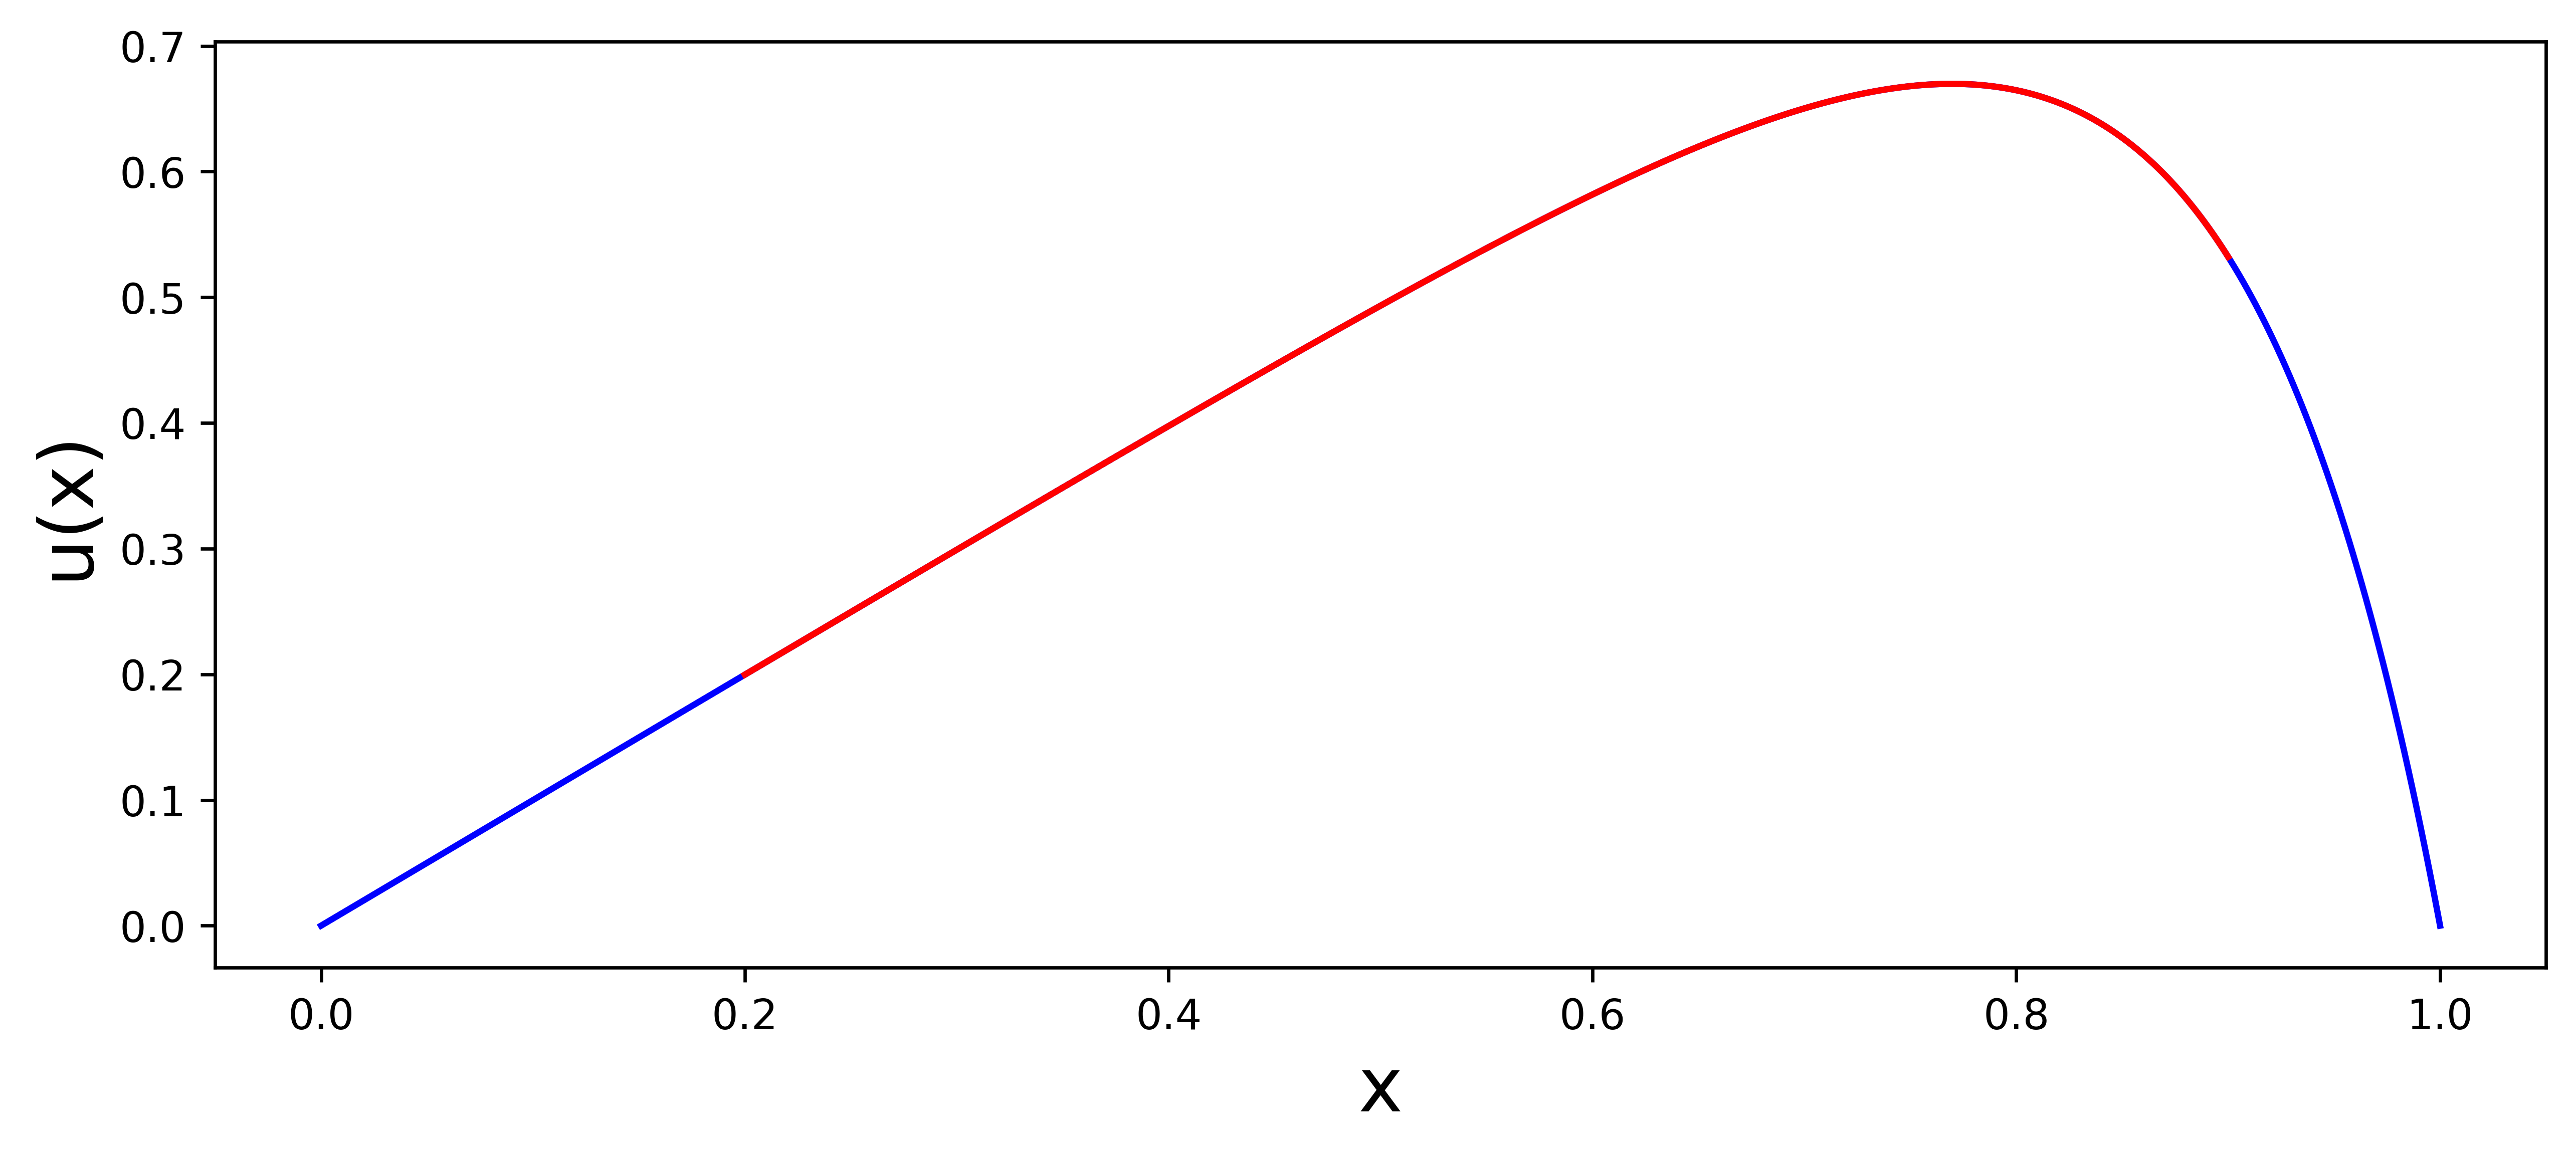

In [6]:
n_FOM = 2**9

xl = 0.2
xr = 0.9
x = np.linspace(xl, xr, num=n_FOM)
h = x[1] - x[0]
nu=0.1
beta=1

pde1 = PDE_1D_Steady_AdvecDiff(nu=nu, beta=beta)

u_0 = pde1.f(xl)
u_n = pde1.f(xr)

u = np.array([[u_0], [u_n]])

a = beta/(2*h) - nu/(h**2)
b = (2*nu)/(h**2)
c = -(nu/(h**2)) - (beta/(2*h))

A = np.diagflat([b]*(n_FOM-2)) + np.diagflat([c]*(n_FOM - 3), -1) + np.diagflat([a]*(n_FOM - 3), 1)

f = np.ones((n_FOM-2, 1))

f[0] += -c*u_0
f[-1] += -a*u_n

u_int = np.linalg.solve( A, f )

u = np.hstack((np.hstack((u_0, u_int.flatten())), u_n))

#print(u)

x_true = np.linspace(0, 1, num=1001)
u_true = pde1.f(x_true)

fig, ax = plt.subplots(1,1, figsize=(10,4), dpi=600)

ax.plot(x_true, u_true, 'b-', x, u, 'r-')
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('u(x)', fontsize=18)